In [1]:
import I2MC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
opt = dict()
# General variables for eye-tracking data
# maximum value of horizontal resolution in pixels
opt['xres'] = 1920.0
opt['yres'] = 1080.0  # maximum value of vertical resolution in pixels
# missing value for horizontal position in eye-tracking data (example data uses -xres). used throughout
# internal_helpers as signal for data loss
opt['missingx'] = -opt['xres']
# missing value for vertical position in eye-tracking data (example data uses -yres). used throughout
# internal_helpers as signal for data loss
opt['missingy'] = -opt['yres']
# sampling frequency of data (check that this value matches with values actually obtained from measurement!)
opt['freq'] = 250.0

# Variables for the calculation of visual angle
# These values are used to calculate noise measures (RMS and BCEA) of
# fixations. The may be left as is, but don't use the noise measures then.
# If either or both are empty, the noise measures are provided in pixels
# instead of degrees.
# screen size in cm
opt['scrSz'] = [55.0, 32.5]
# distance to screen in cm.
opt['disttoscreen'] = 65.0

## STEFFEN INTERPOLATION
## max duration (s) of missing values for interpolation to occur
#opt['windowtimeInterp'] = 0.1
## amount of data (number of samples) at edges needed for interpolation
#opt['edgeSampInterp'] = 2
## maximum displacement during missing for interpolation to be possible
#opt['maxdisp'] = opt['xres'] * 0.2 * np.sqrt(2)
#
## # K-MEANS CLUSTERING
## time window (s) over which to calculate 2-means clustering (choose value so that max. 1 saccade can occur)
#opt['windowtime'] = 0.2
## time window shift (s) for each iteration. Use zero for sample by sample processing
#opt['steptime'] = 0.02
## maximum number of errors allowed in k-means clustering procedure before proceeding to next file
#opt['maxerrors'] = 100
#opt['downsamples'] = [2, 5, 10]
## use chebychev filter when down sampling? 1: yes, 0: no. requires signal processing toolbox. is what matlab's
## down sampling internal_helpers do, but could cause trouble (ringing) with the hard edges in eye-movement data
#opt['downsampFilter'] = False
#
## # FIXATION DETERMINATION
## number of standard deviations above mean k-means weights will be used as fixation cutoff
#opt['cutoffstd'] = 2.0
## number of MAD away from median fixation duration. Will be used to walk forward at fixation starts and backward at
## fixation ends to refine their placement and stop algorithm from eating into saccades
#opt['onoffsetThresh'] = 3.0
## maximum Euclidean distance in pixels between fixations for merging
#opt['maxMergeDist'] = 40.0
## maximum time in ms between fixations for merging
#opt['maxMergeTime'] = 60.0
## minimum fixation duration after merging, fixations with shorter duration are removed from output
#opt['minFixDur'] = 90.0

1-IsPrime: Fixation Calculation


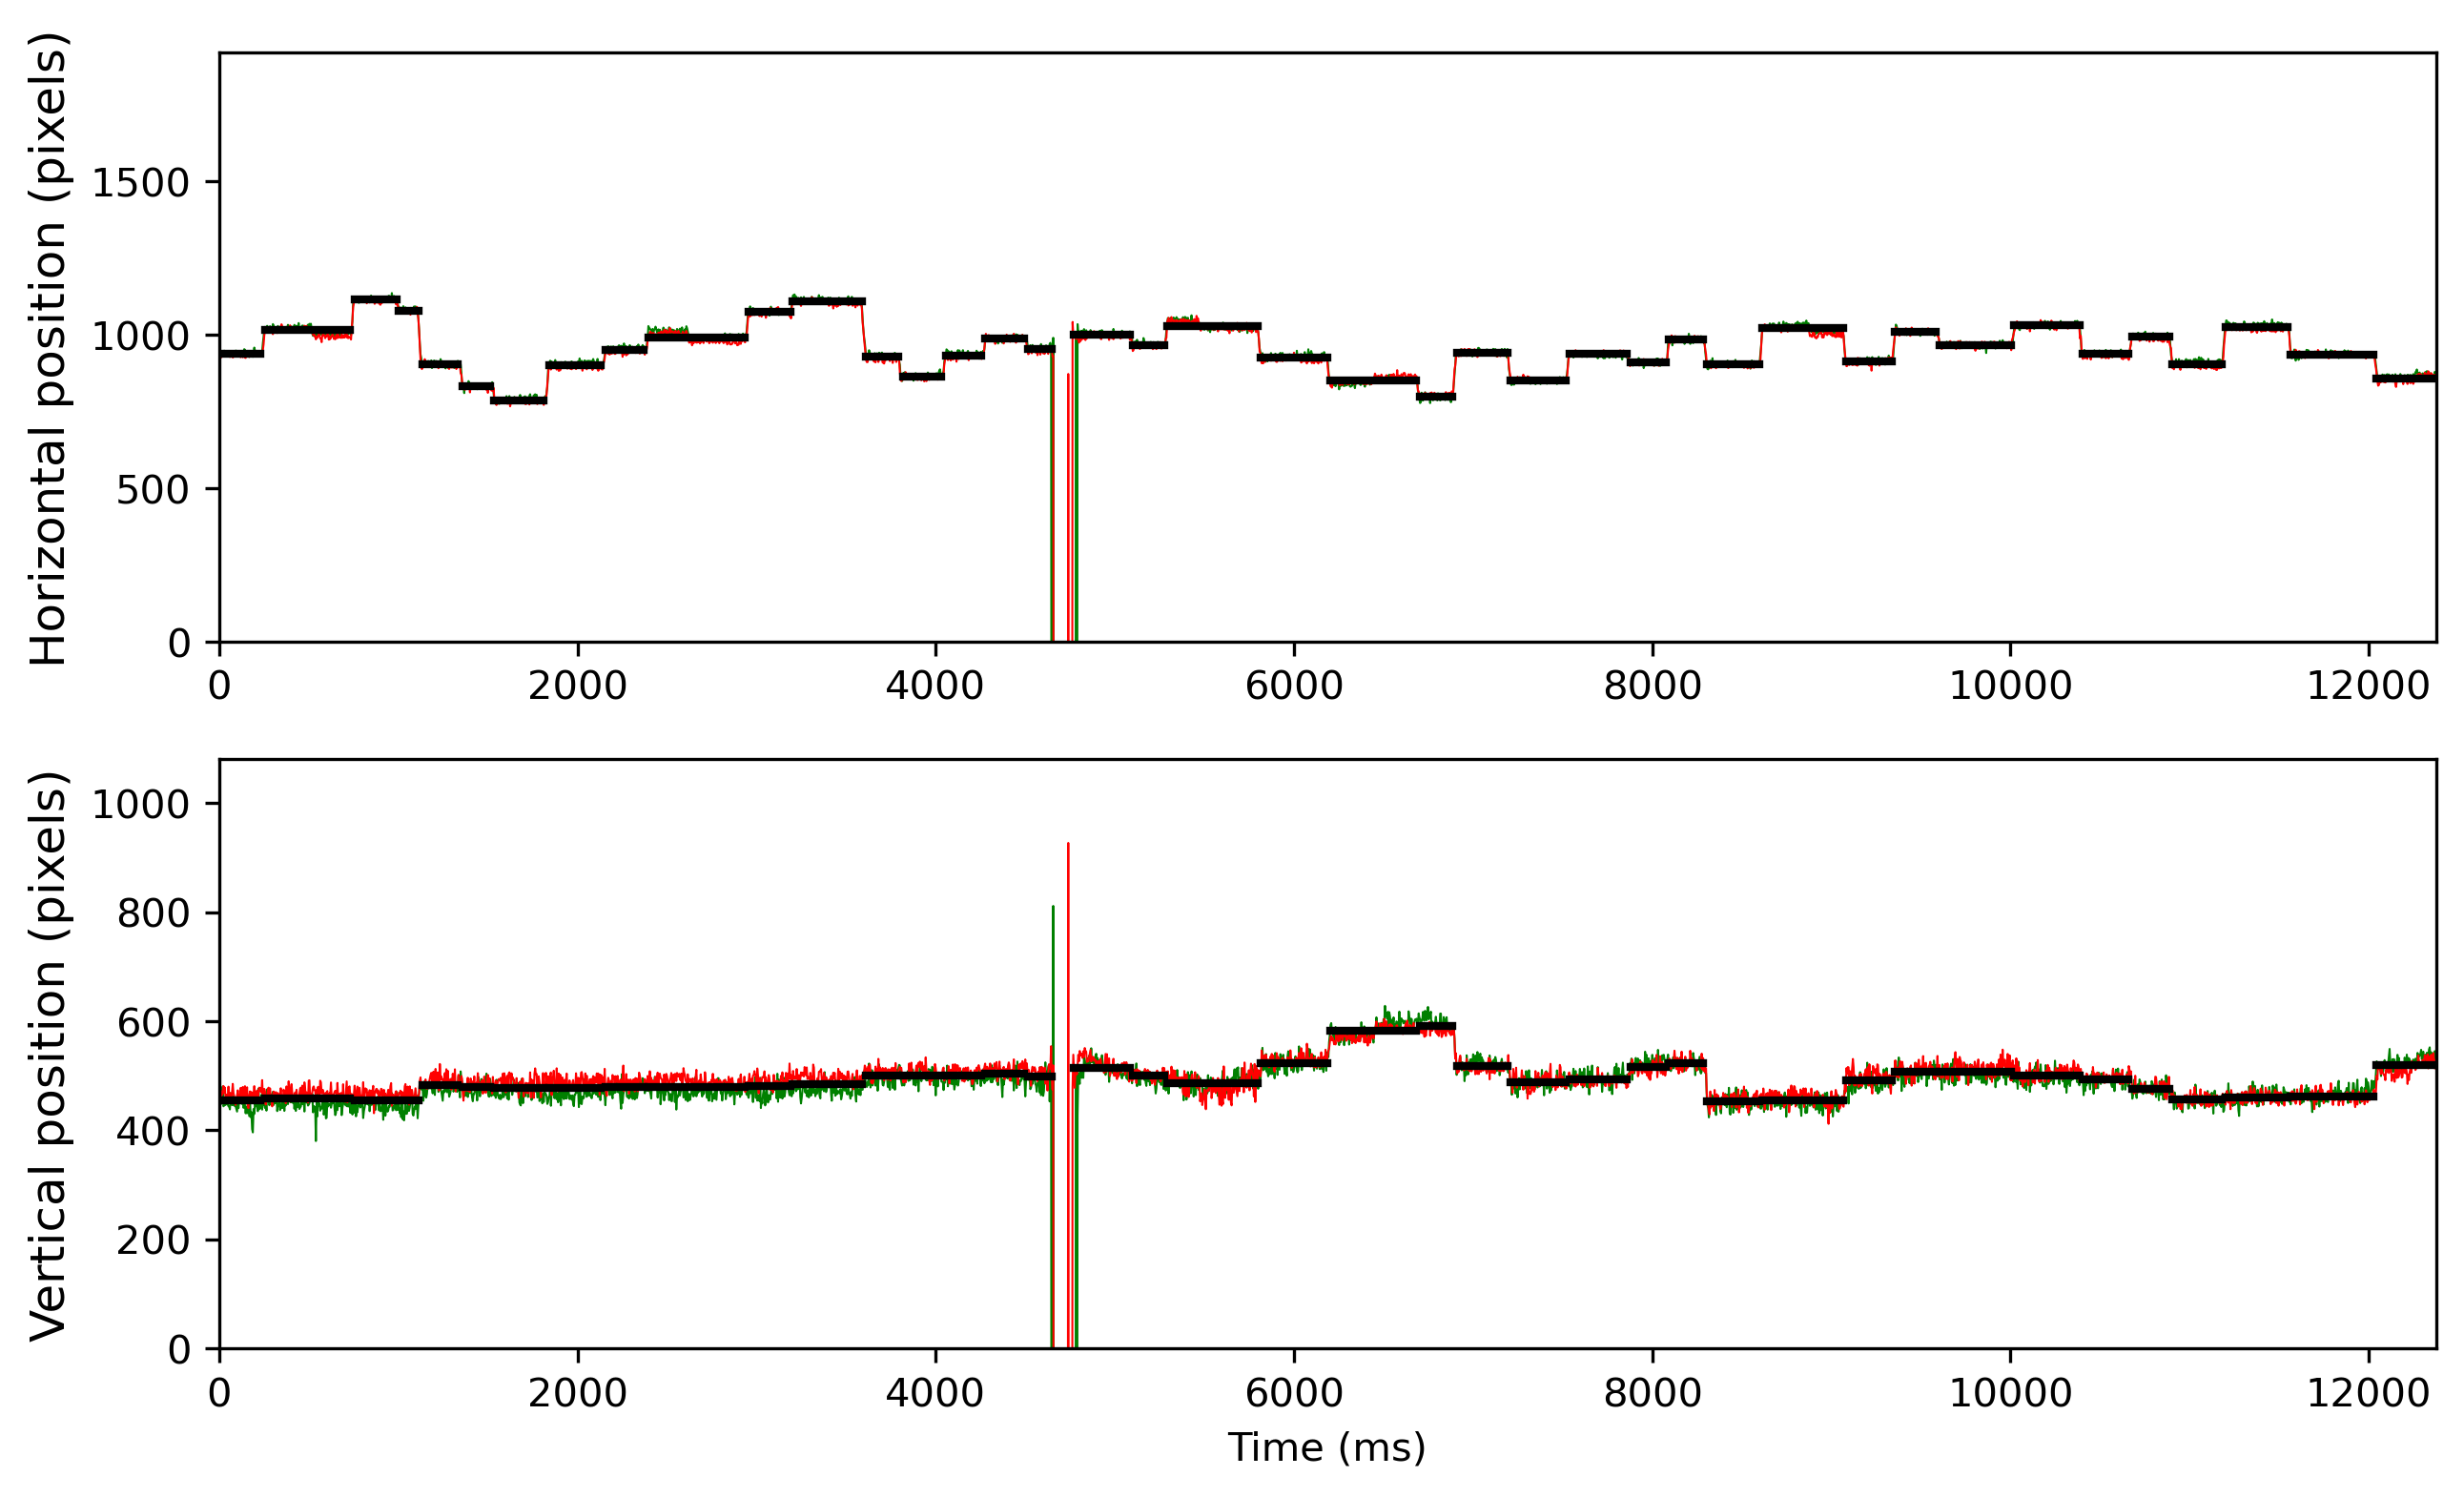

{'cutoff': 1.4095751350973427,
 'start': array([   0,   64,  189,  250,  284,  339,  384,  460,  539,  599,  739,
         800,  903,  954, 1014, 1069, 1129, 1192, 1275, 1323, 1454, 1550,
        1675, 1727, 1802, 1884, 1970, 2023, 2076, 2154, 2270, 2339, 2401,
        2505, 2600, 2670, 2725, 2800, 2891, 3011]),
 'end': array([  58,  183,  248,  278,  333,  378,  453,  533,  593,  733,  797,
         897,  948, 1008, 1063, 1123, 1162, 1271, 1319, 1449, 1546, 1670,
        1721, 1798, 1879, 1965, 2019, 2071, 2149, 2266, 2334, 2396, 2501,
        2596, 2665, 2721, 2795, 2886, 3006, 3093]),
 'startT': array([    0.   ,   256.007,   756.017,  1000.023,  1136.027,  1356.034,
         1536.038,  1840.047,  2156.055,  2396.061,  2956.074,  3200.082,
         3612.09 ,  3816.098,  4056.101,  4276.107,  4516.112,  4768.119,
         5100.127,  5292.132,  5816.148,  6200.162,  6700.173,  6908.183,
         7208.194,  7536.201,  7880.214,  8092.217,  8304.228,  8616.239,
         9080.252,  9356.

AssertionError: 

In [4]:
df_behavioral = pd.read_csv("./data/filteredData/filtered_data.csv")
#iterate through each row
for index, row in df_behavioral.iterrows():
    print("{}-{}: Fixation Calculation".format(row["Participant"], row["Algorithm"]))
    df_eyetracking = pd.read_csv(row["Eyetracking"])
    df_eyetracking["time"] = df_eyetracking["time"].astype(float)
    df_eyetracking["time"] = df_eyetracking["time"] - df_eyetracking["time"].iloc[0]
    # drop col
    df_eyetracking = df_eyetracking.drop(columns=["l_gaze_point_in_user_coordinate_system_x",
                                                  "l_gaze_point_in_user_coordinate_system_y",
                                                  "l_gaze_point_in_user_coordinate_system_z",
                                                  "r_gaze_point_in_user_coordinate_system_x",
                                                  "r_gaze_point_in_user_coordinate_system_y",
                                                  "r_gaze_point_in_user_coordinate_system_z",
                                                  "l_gaze_origin_in_user_coordinate_system_x",
                                                  "l_gaze_origin_in_user_coordinate_system_y",
                                                  "l_gaze_origin_in_user_coordinate_system_z",
                                                  "r_gaze_origin_in_user_coordinate_system_x",
                                                  "r_gaze_origin_in_user_coordinate_system_y",
                                                  "r_gaze_origin_in_user_coordinate_system_z"])

    df_eyetracking["l_display_x"] = df_eyetracking["l_display_x"].astype(float) * opt["xres"]
    df_eyetracking["l_display_y"] = df_eyetracking["l_display_y"].astype(float) * opt["yres"]
    df_eyetracking["r_display_x"] = df_eyetracking["r_display_x"].astype(float) * opt["xres"]
    df_eyetracking["r_display_y"] = df_eyetracking["r_display_y"].astype(float) * opt["yres"]
    df_eyetracking["l_valid"] = df_eyetracking["l_valid"].astype(int)
    df_eyetracking["r_valid"] = df_eyetracking["r_valid"].astype(int)

    df_eyetracking["l_miss_x"] = df_eyetracking.apply(lambda row: row["l_display_x"] < -opt["xres"] or row["l_display_x"] > 2 * opt["xres"], axis=1)
    df_eyetracking["l_miss_y"] = df_eyetracking.apply(lambda row: row["l_display_y"] < -opt["yres"] or row["l_display_y"] > 2 * opt["yres"], axis=1)
    df_eyetracking["r_miss_x"] = df_eyetracking.apply(lambda row: row["r_display_x"] < -opt["xres"] or row["r_display_x"] > 2 * opt["xres"], axis=1)
    df_eyetracking["r_miss_y"] = df_eyetracking.apply(lambda row: row["r_display_y"] < -opt["yres"] or row["r_display_y"] > 2 * opt["yres"], axis=1)

    df_eyetracking["l_miss"] = df_eyetracking.apply(lambda row: row["l_miss_x"] or row["l_miss_y"] or not row["l_valid"] >= 1, axis=1)
    df_eyetracking["r_miss"] = df_eyetracking.apply(lambda row: row["r_miss_x"] or row["r_miss_y"] or not row["r_valid"] >= 1, axis=1)

    df_eyetracking.loc[df_eyetracking["l_miss"], "l_display_x"] = opt["missingx"]
    df_eyetracking.loc[df_eyetracking["l_miss"], "l_display_y"] = opt["missingy"]
    df_eyetracking.loc[df_eyetracking["r_miss"], "r_display_x"] = opt["missingx"]
    df_eyetracking.loc[df_eyetracking["r_miss"], "r_display_y"] = opt["missingy"]

    df_eyetracking = df_eyetracking.drop(columns=["l_miss_x", "l_miss_y", "r_miss_x", "r_miss_y", "l_miss", "r_miss"])

    df_eyetracking.rename(columns={"l_display_x": "L_X",
                                   "l_display_y": "L_Y",
                                   "r_display_x": "R_X",
                                   "r_display_y": "R_Y",
                                   "l_valid" : "LValidity",
                                   "r_valid" : "RValidity"}, inplace=True)

    df_eyetracking["time"] = df_eyetracking["time"].astype(float) * 1000.0

    data = {}
    data["L_X"] = df_eyetracking["L_X"].to_numpy()
    data["L_Y"] = df_eyetracking["L_Y"].to_numpy()
    data["R_X"] = df_eyetracking["R_X"].to_numpy()
    data["R_Y"] = df_eyetracking["R_Y"].to_numpy()
    data["LValidity"] = df_eyetracking["LValidity"].to_numpy()
    data["RValidity"] = df_eyetracking["RValidity"].to_numpy()
    data["time"] = df_eyetracking["time"].to_numpy()
    # rename columns
    try:
        fix, data, par = I2MC.I2MC(data, opt, logging=False)
    except Exception as e:
        print('\t\tError in file: {}'.format(e))
        continue

    if not fix:
        print('{}-{}: Fixation calculation had some Problem'.format(row["Participant"], row["Algorithm"]))
        continue

    ## PLOT RESULTS
    # pre-allocate name for saving file
    f = I2MC.plot.plot_data_and_fixations(data, fix, fix_as_line=True, res=[opt['xres'], opt['yres']])
    # save figure and close
    plt.show()
    plt.close(f)

    #df_eyetracking["FixationNumber"] = np.nan
    #df_eyetracking["FixationDuration"] = np.nan
    #df_eyetracking["FixationX"] = np.nan
    #df_eyetracking["FixationY"] = np.nan
    #df_eyetracking["FixationFlankedDataLoss"] = np.nan
    #df_eyetracking["FixationFracInterpreted"] = np.nan
    #df_eyetracking["FixationRMSxy"] = np.nan
    #df_eyetracking["FixationBCEA"] = np.nan
    #df_eyetracking["FixationRangeX"] = np.nan
    #df_eyetracking["FixationRangeY"] = np.nan
    #
    display(fix)
    assert False